## **Predictor + GAN Student Performance Network**

Goal: This part of the project is more exploratory, to see if we can build a neural net architecture that can accurately predict using all of the features given, not just the ones that we have shown to have a strong correlation with the G3 score. By experimenting this way, we gain overall insight into whether its reliable to predict G3 score from the data given. Then, we expand upon this by using a GAN to generate simulated student data, to see if the prediction network could be generalized to fit a larger population of students. We send the new data through the GAN, then see if the predicted G3 scores are within a reasonable range. So all in all, this is an aggregate testing of our hypotheses.

## **Imports, Installs, and Environment Setup**

In [40]:
# type: ignore

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold


## **Data Preprocessing**

#### **Categorical to Numeric Feature Conversion**

In [8]:
# Function: Converts all categorical columns to numeric
def X_prep(X):
    X_copy = X.copy()
    for col_name, col_data in X.items():
        if col_data.dtype == 'object':
            encoder = LabelEncoder()
            numeric_col = encoder.fit_transform(col_data)
            X_copy[col_name] = numeric_col

    # assert none of the columns are categorical
    assert all(X_copy[col].dtype != 'object' for col in X_copy.columns)

    return X_copy

#### **Normalization**

In [9]:
# Function: Normalizes each column by ranging the values from [0,1]
def normalize(X):
    X_copy = X.copy()
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(X_copy)

## **Preprocessing the Dataset**

In [34]:
excl_cols = ['G1', 'G2']
data = pd.read_csv(r'data/student-por.csv').drop(excl_cols, axis=1)
y = data['G3']
X = data.drop(['G3'], axis = 1)

# Pre Processing X
X = X_prep(X)
X = normalize(X)

## **The Predictor Network**

In [55]:
def predictor(input_size, num_hidden, hidden_size):
    model = Sequential()
    model.add(Dense(hidden_size, input_shape = (input_size,), activation = 'relu'))
    for i in range(num_hidden - 1):
        model.add(Dense(hidden_size, activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mse')
    return model

## **Training & Evaluating Predictor Network**

In [156]:
# Define networks
predictorNet_1_32 = predictor(X.shape[1], 1, 32)
predictorNet_2_32 = predictor(X.shape[1], 2, 32)
predictorNet_1_64 = predictor(X.shape[1], 1, 64)
predictorNet_2_64 = predictor(X.shape[1], 2, 64)
predictorNet_4_32 = predictor(X.shape[1], 4, 32)
predictorNet_4_64 = predictor(X.shape[1], 4, 64)

# Train networks and get loss per epoch
epochs = 100
batch_size = 32
loss_1_32 = predictorNet_1_32.fit(X, y, epochs = epochs, batch_size = batch_size, verbose = 0).history['loss']
loss_2_32 = predictorNet_2_32.fit(X, y, epochs = epochs, batch_size = batch_size, verbose = 0).history['loss']
loss_1_64 = predictorNet_1_64.fit(X, y, epochs = epochs, batch_size = batch_size, verbose = 0).history['loss']
loss_2_64 = predictorNet_2_64.fit(X, y, epochs = epochs, batch_size = batch_size, verbose = 0).history['loss']
loss_4_32 = predictorNet_4_32.fit(X, y, epochs = epochs, batch_size = batch_size, verbose = 0).history['loss']
loss_4_64 = predictorNet_4_64.fit(X, y, epochs = epochs, batch_size = batch_size, verbose = 0).history['loss']

1 Layer 32 Neuron Final Loss: 7.2927446365356445
2 Layer 32 Neuron Final Loss: 4.8323845863342285
1 Layer 64 Neuron Final Loss: 7.235529899597168
2 Layer 64 Neuron Final Loss: 1.950333595275879
4 Layer 32 Neuron Final Loss: 1.859000325202942
4 Layer 64 Neuron Final Loss: 0.7631422281265259


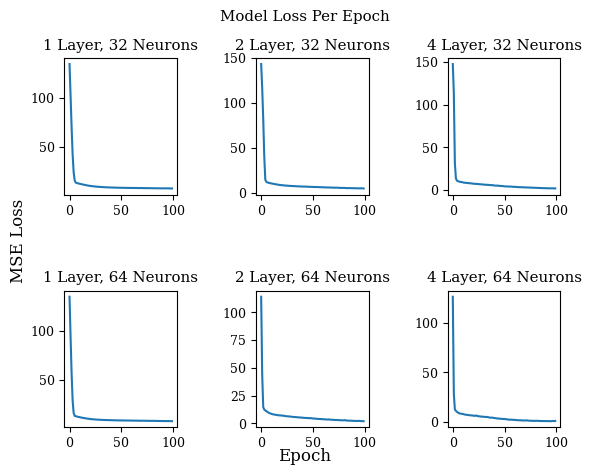

In [67]:
# Plot the loss per epoch for each model
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 9
fig, axs = plt.subplots(2, 3)
num_epochs = np.arange(epochs)
fig.suptitle('Model Loss Per Epoch')
fig.text(0.5, 0.04, 'Epoch', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'MSE Loss', va='center', rotation='vertical', fontsize=12)
fig.subplots_adjust(wspace=0.7, hspace=0.7)

axs[0, 0].plot(num_epochs, loss_1_32)
axs[0, 0].set_title("1 Layer, 32 Neurons")

axs[0, 1].plot(num_epochs, loss_2_32)
axs[0, 1].set_title("2 Layer, 32 Neurons")

axs[1, 0].plot(num_epochs, loss_1_64)
axs[1, 0].set_title("1 Layer, 64 Neurons")

axs[1, 1].plot(num_epochs, loss_2_64)
axs[1, 1].set_title("2 Layer, 64 Neurons")

axs[0, 2].plot(num_epochs, loss_4_32)
axs[0, 2].set_title("4 Layer, 32 Neurons")

axs[1, 2].plot(num_epochs, loss_4_64)
axs[1, 2].set_title("4 Layer, 64 Neurons")

print(f'1 Layer 32 Neuron Final Loss: {loss_1_32[-1]}')
print(f'2 Layer 32 Neuron Final Loss: {loss_2_32[-1]}')
print(f'1 Layer 64 Neuron Final Loss: {loss_1_64[-1]}')
print(f'2 Layer 64 Neuron Final Loss: {loss_2_64[-1]}')
print(f'4 Layer 32 Neuron Final Loss: {loss_4_32[-1]}')
print(f'4 Layer 64 Neuron Final Loss: {loss_4_64[-1]}')

In [158]:
# Now, 10-Fold Cross Validation to return mean MSE of the models
num_folds = 10
kf = KFold(n_splits=num_folds)

models = [predictorNet_1_32, predictorNet_2_32, predictorNet_1_64, predictorNet_2_64, predictorNet_4_32, predictorNet_4_64]
acc = []

for model in models:
    fold_accuracy = []
    for train_index, test_index in kf.split(X):
        # Split the data into training and validation sets for this fold
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        # Train the model on the training set for this fold
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose = 0)

        # Evaluate the model on the validation set for this fold
        mse = model.evaluate(X_val, y_val, verbose = 0)
        fold_accuracy.append(mse)

        # Reset the model for the next fold
        model.reset_states()
    acc.append(np.mean(fold_accuracy))

Mean MSE for 10-Fold CV, by Model: [5.730597114562988, 4.479980826377869, 5.801472949981689, 1.4809739768505097, 2.552342927455902, 0.15034100338816642]


Text(0, 0.5, 'MSE Loss')

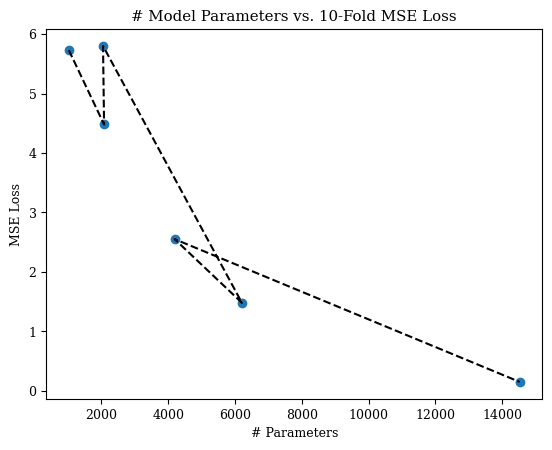

In [159]:
# Print Mean MSE
print(f'Mean MSE for 10-Fold CV, by Model: {acc}')
# Plot model parameter size vs. 10-Fold Loss
num_params_list = []
for model in models:
    num_params = model.count_params()
    num_params_list.append(num_params)

plt.scatter(num_params_list, acc)
plt.plot(num_params_list, acc, linestyle = '--', color = 'black',)
plt.title("# Model Parameters vs. 10-Fold MSE Loss")
plt.xlabel("# Parameters")
plt.ylabel("MSE Loss")

From the loss curves and the 10-Fold Cross Validation, it seems that the 4 layer, 64 neuron each layer network predicts the G3 score very well, with an average MSE of .29. Subjectively speaking, this is a good measure, as its within 1 value of the actual score.

Now, lets build a GAN, simulate extra data, and do 10-Fold on the Predictor Networks, with the combination of real + simulated data.

## **The Generator & Discriminator Network**

In [139]:
def generator(noise_dim, num_hidden, hidden_size, output_size):
    model = Sequential()
    model.add(Dense(hidden_size, input_shape = (noise_dim,), activation = 'relu'))
    for i in range(num_hidden - 1):
        model.add(Dense(hidden_size, activation = 'relu'))
    model.add(Dense(output_size, activation = 'relu'))
    return model

def generator_loss(disc_fake_predictions):
    return cross_entropy(tf.ones_like(disc_fake_predictions), disc_fake_predictions)

generator_optimizer = tf.keras.optimizers.Adam()

def discriminator(input_size, num_hidden, hidden_size):
    model = Sequential()
    model.add(Dense(hidden_size, input_shape = (input_size,), activation = 'relu'))
    for i in range(num_hidden - 1):
        model.add(Dense(hidden_size, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

def discriminator_loss(disc_real_predictions, disc_fake_predictions):
    real_loss = cross_entropy(tf.ones_like(disc_real_predictions), disc_real_predictions)
    fake_loss = cross_entropy(tf.zeros_like(disc_fake_predictions), disc_fake_predictions)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_optimizer = tf.keras.optimizers.Adam()

def get_noise(batch_size, noise_dim = 128):
    return np.random.normal(0, 1, (batch_size, noise_dim))

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def create_batches(df, batch_size, shuffle=True):
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    num_batches = (len(df) + batch_size - 1) // batch_size  # Round up division
    batches = [df.iloc[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    return batches

## **Training the GAN**



In [144]:
epochs = 150
batch_size = 32
noise_dim = 128

gen = generator(noise_dim, 8, 64, X.shape[1])
disc = discriminator(X.shape[1],8, 64)

gen_loss_epoch= []
disc_loss_epoch = []
for epoch in range(epochs):
    batches = create_batches(pd.DataFrame(X), batch_size)
    gen_loss_batch = 0
    disc_loss_batch = 0
    batch_num = 0
    for real_data in batches:
        # Train Discriminator
        with tf.GradientTape() as disc_tape:
            real_predictions = disc(real_data.values)
            noise = get_noise(real_data.shape[0])
            fake_data = gen(noise)
            fake_predictions = disc(fake_data)
            disc_loss = discriminator_loss(real_predictions, fake_predictions)
        disc_loss_batch += disc_loss
        disc_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(disc_gradients, disc.trainable_variables))

        # Train Generator
        noise = get_noise(real_data.shape[0])
        with tf.GradientTape() as gen_tape:
            fake_data = gen(noise)
            fake_predictions = disc(fake_data)
            gen_loss = generator_loss(fake_predictions)
        gen_loss_batch += gen_loss
        gen_gradients = gen_tape.gradient(gen_loss, gen.trainable_variables)
        generator_optimizer.apply_gradients(zip(gen_gradients, gen.trainable_variables))

        batch_num += 1
    gen_loss_epoch.append(gen_loss_batch / batch_num)
    disc_loss_epoch.append(disc_loss_batch / batch_num)


Final Generator BCE Loss: 0.6539852023124695
Final Discriminator BCE Loss: 1.3518595695495605


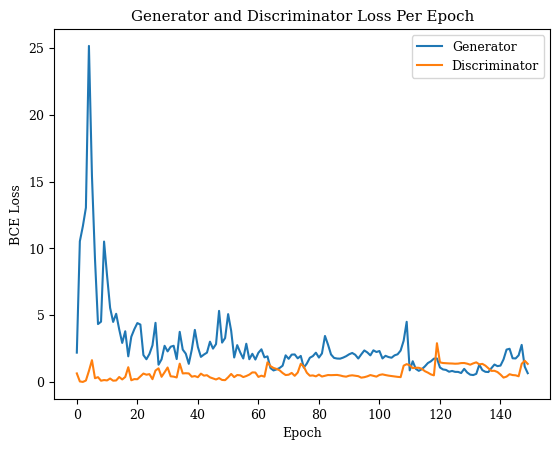

In [146]:
num_epochs = np.arange(epochs)
plt.plot(num_epochs, gen_loss_epoch, label = "Generator")
plt.plot(num_epochs, disc_loss_epoch, label = "Discriminator")
plt.title("Generator and Discriminator Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
print(f'Final Generator BCE Loss: {gen_loss_epoch[-1]}')
print(f'Final Discriminator BCE Loss: {disc_loss_epoch[-1]}')

## **Sending Simulated Data through GAN**

In [150]:
noise = get_noise(500)
simulated_data = gen(noise)
predicted_scores = predictorNet_4_64(simulated_data)
print(f'Lowest Predicted Score: {min(predicted_scores)} vs. Lowest Actual Score: {min(y)}')
print(f'Highest Predicted Score: {max(predicted_scores)} vs. Highest Actual Score: {max(y)}')

Lowest Predicted Score: [9.398534] vs. Lowest Actual Score: 0
Highest Predicted Score: [15.537178] vs. Highest Actual Score: 19


## **Results & Interpretation**

The best predictor network was the 4 Hidden Layer, 64 Node / Layer. The network was trained using 10-Fold CV on the actual data, outputting an MSE error of 0.30. Given that the predicted output range was from 0 to 20, a .30 CV is excellent. So, using a neural network, all of the features combined do predict G3 score accurately, and fit well. This supports our hypothesis. With the non deep learning models, they couldn't predict G3 score with all of the variables; a small subset had to be used. So this experiment was very significant. 

Next, we trained a GAN over 150 epochs to generate simulated data. Then, we generated 500 fake samples, and fed them through the trained predictor network. This resulted in a predicted G3 score in the range of 9.40 to 15.54. For the actual G3 scores, the range was from 0 to 20. So, the predicted scores were actually reasonable. This gives us a hint that the generative model was decently trained. We could further hypothesize that if given more, real student performance data, the predictor network would perform well.

## **Future Improvements**

- More GAN validation/testing
- More real data
- More hyperparameter tuning